# Project: Investigate a Dataset

## Introduction

This project is submitted as a partial requirement for Udacity's Data Analyst Nanodegree program. The objective was to complete a cursory data analysis on a curated data set using NumPy and Pandas. For the project, I chose to investigate the 'Titanic' data set, which includes demographic and passenger information from approximately 40% of the passenger and crew of the ship's infamous last voyage. At the outset of the project, the first question I asked was _"What factors can be used to predict the individuals that were more likely to survive?"_

## Getting acquainted with the 'Titanic' Data Set

To begin investigating the 'Titanic' data set, I loaded the requisite python libraries, including NumPy and Pandas.

In [394]:
# -*- coding: utf-8 -*-

from collections import defaultdict
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import re
from scipy.stats.distributions import norm
import seaborn as sns

%matplotlib inline

I loaded the data file, 'titanic-data.csv', into a data frame with Pandas. Then, I looked at the names of each factor and the dimensions of the data frame. For the factors that were numerical, I performed a summary.

In [395]:
df = pd.read_csv('titanic-data.csv')
print('The data frame has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print(df.columns)
df.describe()

The data frame has 891 rows and 12 columns.
Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Based on the summary, I found that the overall survival rate of the sample was 38%. To make the column names easier to work with, I changed the names to 'snake' form.

In [396]:
df.rename(columns={'PassengerId': 'passenger_id', 
                   'Pclass': 'p_class', 
                   'Survived': 'survived', 
                   'Name': 'name',
                   'Sex': 'sex', 
                   'Age': 'age', 
                   'SibSp': 'sib_sp', 
                   'Parch': 'par_ch', 
                   'Ticket': 'ticket',
                   'Fare': 'fare', 
                   'Cabin': 'cabin',
                   'Embarked': 'embarked'},
          inplace=True)
print(df.columns)

Index([u'passenger_id', u'survived', u'p_class', u'name', u'sex', u'age',
       u'sib_sp', u'par_ch', u'ticket', u'fare', u'cabin', u'embarked'],
      dtype='object')


Having inspected the available features in the dataset, I started to ask more granular questions related to survival. For instance:  
* Did passengers with higher social status have a better chance of surviving?
* Did children have a greater chance of surviving than adults?
* Did the number of people in a person's family influence her chances of survival?
* Did people on lower decks have a lower chance of surviving?

I also had some other questions simply based on curiosity, such as:  
* Can I extract any intersting information from the passengers' names?
* Who paid the most to travel on this voyage? Did he/she survive?

## Modified Features

I needed to transform some of the data to be more useful to my analysis. For example, I combined the features representing immediate family ('sib_sp': siblings/spouse, and 'par_ch': parents/childen) into one feature called 'family_size' (using vector addition available with the Pandas package and with its underlying Numpy capabilities).

In [397]:
# Calculate size of families on the Titanic. Add 1 to include the individual.
df['family_size'] = 1 + df.sib_sp + df.par_ch

df.family_size.dropna().describe()

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: family_size, dtype: float64

The deck level was embedded in the room number, as seen by inspecting some values from that column:

In [398]:
df.cabin.dropna().head(10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: cabin, dtype: object

To extract the deck level, I used a regular expression to identify letters at the beginning of room numbers. For entries that contained multiple room numbers, I utilized the first listed room number. This simplification seemed justified, since a cursory inspection revealed that most entries with multiple room numbers had rooms clustered on the same deck. I also ordered the decks with 'A' being the top deck of the ship and 'G' being the lowest.

In [399]:
# Extract the deck value from the cabin value and create a separate column
deck_re = re.compile(r'[A-G]\d+')
df['cabin_deck'] = np.nan
df['cabin_deck'] = df['cabin_deck'].astype('category', categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
for i, cabin in df['cabin'].iteritems():
    if deck_re.search(str(cabin)):
        deck = deck_re.search(cabin).group()[0]
        df.loc[i, 'cabin_deck'] = deck
    else:
        continue
        
df.cabin_deck.dropna().unique()

[C, E, G, D, A, B, F]
Categories (7, object): [A < B < C < D < E < F < G]

Finally, I noticed that most of the passengers were assigned a title (_e.g._, Mr., Mrs., _etc._). Also, the titles were always abbreviated and followed by a period. Using the presence of the period as an indicator, I extracted the titles from the passenger name and used them to create a new column. Out of curiousity, I printed all the unique values for title.

In [400]:
# Identify an individual's title and create a separate column
title_re = re.compile(r'\w+\.') 
df['title'] = np.nan
for i, name in df['name'].iteritems():
    if title_re.search(name):
        title = title_re.search(name).group()
        df.loc[i, 'title'] = title
    else:
        continue

print(df.title.unique())

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.']


I was unfamiliar with several of the titles. After researching their meanings, I found that they were all non-english titles:    
[Don.](https://en.wikipedia.org/wiki/Don): A spanish honorific title, roughly equivalent to 'Lord'.    
[Mlle.](https://mail.google.com/mail/u/0/?zx=do2a3rl6j9qu#inbox): A french honorific for 'Mademoiselle', a traditional alternative for an unmarried woman.  
[Jonkheer](https://en.wikipedia.org/wiki/Jonkheer): A dutch honorific of nobility.  

## Factors predicting survival  
### Categorical factors

To begin investigating factors that could be used to predict survival, I started by plotting the survival ratio versus the categorical features in the data.

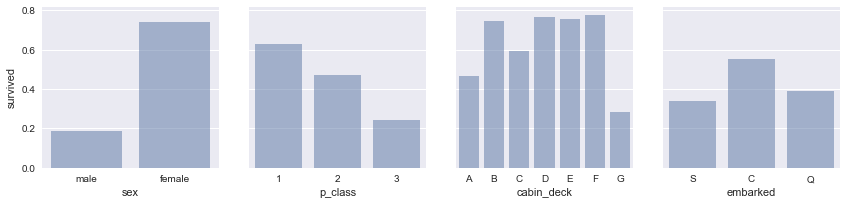

In [401]:
g = sns.PairGrid(data=df, x_vars=['sex', 'p_class', 'cabin_deck', 'embarked'], y_vars='survived', size=3)
g.map(sns.barplot, ci=None, alpha = 0.5)

In my initial estimation, I did not think that sex would be as drastic a predictor for survival. However, sex seemed to be perhaps the most drastic differentiator, with less than 20% of males in the sample surviving and over 70% of females surviving in the sample.  Since sex only had two levels, the feature conveniently lended itself to an inferential statistical test. Using a [two-proportion comparative test](https://onlinecourses.science.psu.edu/stat200/node/61), I started by defining the following hypotheses:  

$H_0$: The proportion of females that survived equals the proportion of males that survived, $\hat{p}_{female}=\hat{p}_{male}$  
$H_a$: The proportion of females that survived does not equal the proportion of males that survived, $\hat{p}_{female}\neq\hat{p}_{male}$  

The test statistic for two independent variables was then defined as follows. (The test assumes that more than 5 observations, $n$, are made for each variable, and the distribution of each approaches the normal distribution.)  

$$z = \frac{(\hat{p}_{female}-\hat{p}_{male})-0}{S.E.}$$  

where  

$$ S.E. = \sqrt{\frac{\hat{p}_{female}(1-\hat{p}_{female})}{n_{female}}+\frac{\hat{p}_{male}(1-\hat{p}_{male})}{n_{male}}}$$

I then wrote a python function, two_proportion_test, to calculate the test statistic and corresponding p-value for the test:

In [247]:
def two_proportion_test(y1, n1, y2, n2, alt='two-sided'):
    """Generate a z test statistic and p-value for a hypothesis test for two proportions from the same population.
    H0: y1/n1 = y2/n2
    Ha: y1/n1 != y2/n2
    
    Parameters
    ----------
        y1 : int
            The number of 'positive' outcomes in the first proportion.
            
        n1 : int
            The number of samples taken for the first proportion.
            
        y2 : int
            The number of 'positive' outcomes in the second proportion.
            
        n2 : int
            The number of samples taken for the second proportion.
            
        alt : str {'two-sided', 'one-sided'}
            An indicator for the alternative hypothesis. Defaults to 'two-sided'
            
    Returns
    -------
    z_stat : float
        The z statistic for the hypothesis test. 
        
    p_value : float
        The p value for the hypothesis test.
    """
    p1 = y1/n1
    p2 = y2/n2
    se = np.sqrt(p1*(1 - p1)/n1 + p2*(1 - p2)/n2)
    z_stat = (p1 - p2)/se
    if alt == 'two-sided':
        if z_stat > 0:
            p_value = (1 - norm.cdf(z_stat))*2
        else:
            p_value = (1 - norm.cdf(-z_stat))*2
    elif alt == 'one-sided':
        if z_stat > 0:
            p_value = (1 - norm.cdf(z_stat))
        else:
            p_value = (1 - norm.cdf(-z_stat))
    else:
        raise ValueError("Parameter 'alt' from function 'two_proportion_test' takes only the values\
                         'one-sided' or 'two-sided'.")
    return (z_stat, p_value)        

I then proceeded to calculate $\hat{p}_{female}$, $n_{female}$, $\hat{p}_{male}$, and $n_{male}$, followed by the test statistic and associated p-value:

In [277]:
females = df[df['sex'] == 'female']
total_females = len(females)
females_survived = sum(females.survived)
males = df[df['sex'] == 'male']
total_males = len(males)
males_survived = sum(males.survived)
print('Total females in sample: %d' % total_females)
print('Survived females in sample: %d' % females_survived)
print('Total males in sample: %d' % total_males)
print('Survived males in sample: %d' % males_survived)

test_results = two_proportion_test(y1=females_survived, 
                                   n1=total_females, 
                                   y2=males_survived, 
                                   n2=total_males)

print('Test statistic: {:.1f}'.format(test_results[0]))
print('p-value: {:.3f}'.format(test_results[1]))

Total females in sample: 314
Survived females in sample: 233
Total males in sample: 577
Survived males in sample: 109
Test statistic: 18.7
p-value: 0.000


From the statistical test, I was able to conclude that the probabilty of the null hypothesis being true was insignificant with an $\alpha$-level of 0.001. Although the test shows that sex was a strong predictor of survival in the population, it does not prove causality. For instance, cultural values (such as prioritizing the life of women and children over that of men) could have been the causal agent rather than an individual's biology.

Looking at the remaining categorical features in the dataset, I thought that two other observations were interesting. First, the survival rate decreased with lower passenger classes. In this case, I did not do a statistical test to show that the trend could be generalized to the population. Again, the trend in survival rate with passenger class does not prove causality, but I would _hypothesize_ that passenger class could be used to approximate social class, and higher social classes were likely given priority to access the Titanic's life boats.

Second, the survival rate of passengers on the lowest deck of the Titanic appeared to be much lower than other decks, and the survival rate on other decks appeared to be more or less similar. The survival rate of passengers lodged on deck A could also be considered relatively low, but deck A was the top deck, and had a [much lower count of passenger rooms than other decks](https://www.encyclopedia-titanica.org/titanic-deckplans/a-deck.html), and was likely different from other decks in other ways as well. The deck variable  appeared to correlate with passenger class (as demonstrated in the following barplot). Consequently, my earlier hypothesis - that passengers on lower decks would have a harder time accessing the top deck and the lifeboats - would have to be treated more rigorously to tease apart the effects from factors related to social status.

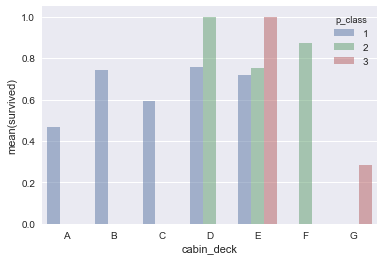

In [378]:
sns.barplot(x='cabin_deck', y='survived', data=df, ci=None, hue='p_class', alpha=0.5)

### Continuous factors  

After looking at the categorical factors, I moved on to visualizing the continuous factors in the dataset. I started with the variable 'fare', which I anticipated could also be used to approximate social class. First, I plotted a histogram to look at the distribution of values, then I plotted the survival rate versus fare, binning fares together in increments of 5£:

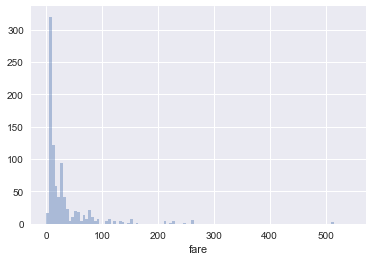

In [334]:
g = sns.distplot(df.fare.dropna(), bins=range(0, 550, 5), kde=False)

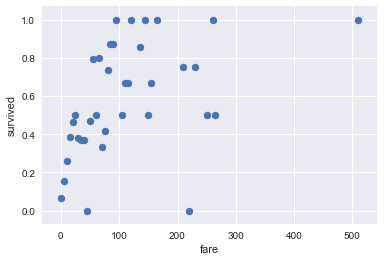

In [388]:
g = sns.regplot(x='fare', y='survived', data=df, x_bins=range(0, 550, 5), fit_reg=False, ci=False, y_jitter=0.01)

Qualitatively, it appears that passengers that paid more were more likely to survive. I was interested to see who was the outlier that paid over £500 for the fare. 

In [393]:
print(df[['name', 'sex', 'age', 'family_size', 'cabin', 'embarked', 'fare']][df.fare > 500])

                                   name     sex   age  family_size  \
258                    Ward, Miss. Anna  female  35.0            1   
679  Cardeza, Mr. Thomas Drake Martinez    male  36.0            2   
737              Lesurer, Mr. Gustave J    male  35.0            1   

           cabin embarked      fare  
258          NaN        C  512.3292  
679  B51 B53 B55        C  512.3292  
737         B101        C  512.3292  


From [encyclopedia-titanica.org](www.encyclopedia-titanica.org), I found that Mr. Thomas Cardeza, his mother Charlotte Cardeza, his manservant Mr. Gustave Lesurer, and his mother's maidservant Miss. Anna Ward, were all traveling together. The were returning to the U.S. from an African safari. 

Seeing that the distribution was highly right-skewed, I wanted to avoid being misled by extreme values. I re-plotted the data with the lower 95% of the data. 

In [356]:
print('95th-percentile: {:0.2f}'.format(df.fare.quantile(0.95)))

95th-percentile: 112.08


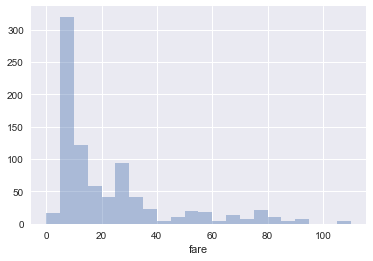

In [359]:
g = sns.distplot(df.fare, bins=range(0, 115, 5), kde=False)

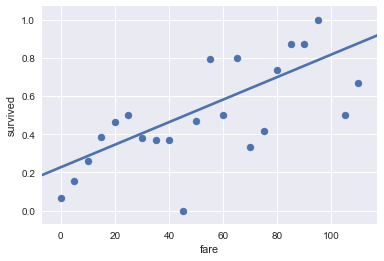

In [357]:
g = sns.regplot(x='fare', y='survived', data=df[df.fare <= 112], x_bins=range(0, 115, 5), ci=False)

The trend appeared to hold. Hence, as part of a exploratory data analysis, fare seems to be a promising predictor for survival. Note, however, that the visualization does not prove a statistical correlation between survival rate and fare. Additionally, another leap needs to be taken to rigorously show that fare can be used as a construct for social status. 

I next investigated whether family size showed a qualitative correlation with survival rate. I performed the same visualizations as above, plotting the distribution of family size as well as the relationship between the variable and survival rate:

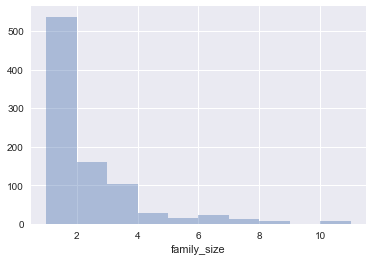

In [315]:
g = sns.distplot(df.family_size, bins=range(1, 12, 1), kde=False)

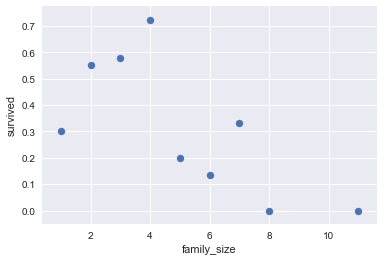

In [302]:
g = sns.regplot(x='family_size', y='survived', data=df, x_bins=range(0, 12, 1), fit_reg=False, ci=False)

The relationsip between family size and survival appears to be non-linear. Individuals that were traveling by themselves as well as people with large families had survival rates below the overall mean. As with the previous feature, the distribution is right-skewed, necessitating a statistical approach to show how strong the predictor is.

Finally, I investigated the effect of age on survial.

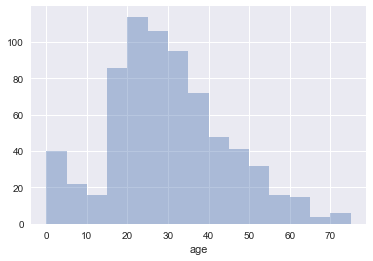

In [341]:
g = sns.distplot(df.age.dropna(), bins=range(0, 80, 5), kde=False)

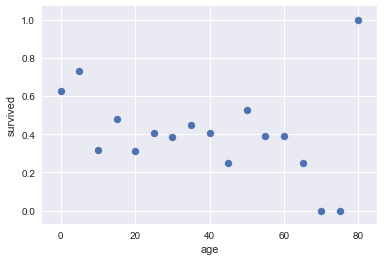

In [336]:
g = sns.regplot(x='age', y='survived', data=df, x_bins=range(0, 100, 5), fit_reg=False, ci=False)

Based on the way I binned the data in the scatter plot, a negative correlation appears to be present (discounting the outlier at age 80). However, I noticed that 50% of the data lies between the ages of 20 and 38 (based on the summary statistics performed at the beginning of the report), and the survival rate in this range of ages is close to the grand mean. Once again, a more rigorous statistical test would be needed to show the strength of age as a predictor of survival.

One of my questions was whether children had a greater chance of surviving as compared to adults. I (somewhat arbitrarilty) defined a cut-off between children and adults at 15 years of age. I omitted individuals who had no reported age. Then, I used the two-proportion test I coded earlier to calculate a test-statistic for significance:

In [377]:
total_children = sum(df.age <= 15)
children_survived = sum((df.age <= 15) & (df.survived == 1))
total_adults = sum(df.age > 15)
adults_survived = sum((df.age > 15) & (df.survived == 1))
print('Number of children (age <= 15):\t\t{}'.format(total_children))
print('Number of children who survived:\t{}'.format(children_survived))
print('Ratio of children who survived: \t{:0.2f}'.format(children_survived/total_children))
print('Number of adults (age > 15):\t\t{}'.format(total_adults))
print('Number of adults who survived:\t\t{}'.format(adults_survived))
print('Ratio of adults who survived:\t\t{:0.2f}'.format(adults_survived/total_adults))

test_results = two_proportion_test(y1=children_survived, 
                                   n1=total_children, 
                                   y2=adults_survived,
                                   n2=total_adults)
print('Test statistic: {:.1f}'.format(test_results[0]))
print('p-value: {:.3f}'.format(test_results[1]))

Number of children (age <= 15):		83
Number of children who survived:	49
Ratio of children who survived: 	0.59
Number of adults (age > 15):		631
Number of adults who survived:		241
Ratio of adults who survived:		0.38
Test statistic: 3.6
p-value: 0.000


Based on the test, I reject the null hypothesis that the proportion of survived children is the same as the proportion of survived adults. 

## Conclusion

In this exploratory data analysis of the Titanic data set, I identified several qualitative correlations between passenger features and passenger survival. Some of the findings were used to draw inferences about the entire population of passengers on the Titanic's last voyage. Running an experiment to rigorously prove causality for survival, however, is pragmatically impossible. Below is a summary of my conclusions based simply on my perceptions of the exploratory analysis and some inferential statistics: 

**1) Did passengers with higher social status have a better chance of surviving?**  
   Using passenger class (p_class) and fare as constructs for social status, individuals with higher social status qualitatively seemed to have a higher chance of survival. 

**2) Did children have a greater chance of surviving than adults?**  
   Defining children as individuals less than or equal to 15 years of age, a statistical test showed that the rate of survival in children was not the same as the rate of survival in adults. 
   
**3) Did the number of people in a person's family influence her chances of survival?**  
   No definite correlation could be ascertained from plotting the data.
   
**4) Did people on lower decks have a lower chance of surviving?**  
   By inspection, people on deck G, the lowest deck, seemed to have a lower chance of surviving. However, I noted that location of an individual's room correlated with passenger class, leading to some uncertainty behind the real story (_e.g._, was it social status or simply difficulty in getting to the lifeboats that influenced survival most?)

**5) Can I extract any interesting information from the passengers' names?**  
   The variety of titles listed in the passengers' names revealed honorifics from other countries that I was unaware of.

**6) Who paid the most to travel on this voyage? Did he/she survive?**  
   Mr. Thomas Cardeza and his entourage paid the most to travel on the Titanic's last voyage: £512 each. The entire group survived.
   
**7) What factors can be used to predict the individuals that were more likely to survive?**  
   With the present analysis, the sex of a passenger and his status as a child or adult appear to be strong predictors for survival.